In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Correct path to the zip file in Google Drive
zip_path = '/content/drive/MyDrive/ValidationDataset.zip'

# Destination path where you want to unzip the file
dest_path = '/content/ValidationDataset'

# Create destination directory if it doesn't exist

os.makedirs(dest_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dest_path)

print("Unzipping completed!")

Unzipping completed!


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, callbacks
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS= 10
n_classes = 2

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/ValidationDataset/ValidationDataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

#dataset = dataset.map(lambda x, y: (x / 255.0, y))

Found 15528 files belonging to 2 classes.


In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:


#Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [ ]:
for images, labels in train_ds.take(1):
    print(labels.numpy())

[0 0 1 0 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1]


In [ ]:
# Define a squeeze-and-excitation block
def se_block(input_tensor, reduction_ratio=4):
    channels = input_tensor.shape[-1]
    reduced_channels = channels // reduction_ratio
    x = layers.GlobalAveragePooling2D()(input_tensor)
    x = layers.Dense(reduced_channels, activation='relu')(x)
    x = layers.Dense(channels, activation='sigmoid')(x)
    return layers.Multiply()([input_tensor, x])

# Define a MBConv block
def mb_conv_block(input_tensor, filters, kernel_size, strides, expansion_factor=6):
    in_channels = input_tensor.shape[-1]
    expanded_channels = in_channels * expansion_factor

    # Expansion
    x = layers.Conv2D(expanded_channels, kernel_size=1, padding='same', use_bias=False)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Depthwise convolution
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Squeeze and Excitation
    x = se_block(x)

    # Projection
    x = layers.Conv2D(filters, kernel_size=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Skip connection
    if strides == 1 and in_channels == filters:
        x = layers.Add()([input_tensor, x])

    return x

# Define the EfficientNet model
def build_efficientnet(input_shape, n_classes):

    inputs = layers.Input(shape=input_shape)
    x = resize_and_rescale(inputs)
    #x = data_augmentation(x)
    # Stem
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Blocks
    x = mb_conv_block(x, filters=8, kernel_size=3, strides=1, expansion_factor=1)
    #x = mb_conv_block(x, filters=16, kernel_size=3, strides=2, expansion_factor=6)
    #x = mb_conv_block(x, filters=40, kernel_size=5, strides=2, expansion_factor=6)
    #x = mb_conv_block(x, filters=80, kernel_size=3, strides=2, expansion_factor=6)
    #x = mb_conv_block(x, filters=112, kernel_size=5, strides=1, expansion_factor=6)
    #x = mb_conv_block(x, filters=192, kernel_size=5, strides=2, expansion_factor=6)
    x = mb_conv_block(x, filters=320, kernel_size=3, strides=1, expansion_factor=6)

    # Head
    x = layers.Conv2D(640, kernel_size=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.8)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = build_efficientnet(input_shape, 2)

In [ ]:
#model.compile(
   # optimizer=tf.keras.optimizers.Adam(),
 #   loss=tf.keras.losses.BinaryCrossentropy(),
  #  metrics=[tf.keras.metrics.BinaryAccuracy()]
#)

model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 112, 112, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 112, 112, 32)   │            128 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 112, 112, 32)   │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 112, 112, 32)   │          1,024 │ activation_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 112, 112, 32)   │            128 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_7 (Activation) │ (None, 112, 112, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d_2        │ (None, 112, 112, 32)   │            288 │ activation_7[0][0]     │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 112, 112, 32)   │            128 │ depthwise_conv2d_2[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_8 (Activation) │ (None, 112, 112, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 32)             │              0 │ activation_8[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 8)              │            264 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 32)             │            288 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_2 (Multiply)     │ (None, 112, 112, 32)   │              0 │ activation_8[0][0],    │
│                           │                        │                │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 112, 112, 8)    │            256 │ multiply_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 112, 112, 8)    │             32 │ conv2d_9[0][0]         │
│ (BatchNormalization) 

 Total params: 230,453 (900.21 KB)

 Trainable params: 228,133 (891.14 KB)

 Non-trainable params: 2,320 (9.06 KB)

In [ ]:
# Define callbacks
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 157s 334ms/step - accuracy: 0.6628 - loss: 0.6217 - val_accuracy: 0.4714 - val_loss: 0.8176 - learning_rate: 1.0000e-05
Epoch 2/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 105s 270ms/step - accuracy: 0.8887 - loss: 0.2840 - val_accuracy: 0.9525 - val_loss: 0.1630 - learning_rate: 1.0000e-05
Epoch 3/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 105s 270ms/step - accuracy: 0.9372 - loss: 0.1740 - val_accuracy: 0.9779 - val_loss: 0.1026 - learning_rate: 1.0000e-05
Epoch 4/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 104s 269ms/step - accuracy: 0.9612 - loss: 0.1223 - val_accuracy: 0.9857 - val_loss: 0.0704 - learning_rate: 1.0000e-05
Epoch 5/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 104s 269ms/step - accuracy: 0.9744 - loss: 0.0850 - val_accuracy: 0.9915 - val_loss: 0.0479 - learning_rate: 1.0000e-05
Epoch 6/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 104s 269ms/step - accuracy: 0.9832 - loss: 0.0635 - val_accuracy: 0.9948 - val_loss: 0.0362 - learning_rate: 1.0000e-05
Epoch 7/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
scores = model.evaluate(test_ds)

50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.9972 - loss: 0.0168


In [ ]:
# Plot accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

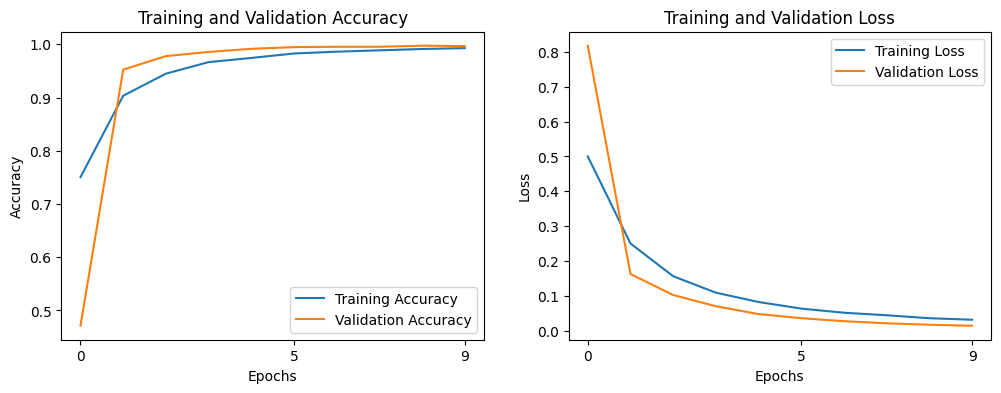

In [ ]:
# Use the length of the actual data (acc and val_acc arrays) for the x-axis
epochs_range = range(len(acc))  # or len(val_acc), they should have the same length

plt.figure(figsize=(12, 4))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(ticks=list(range(0, len(acc), 5)) + [len(acc)-1])  # Add the last epoch to x-axis ticks

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(ticks=list(range(0, len(loss), 5)) + [len(loss)-1])  # Add the last epoch to x-axis ticks

plt.show()


In [ ]:
class_names = dataset.class_names
class_names

['IntestiScan', 'Random']

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    #plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

first image to predict
actual label: Random
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
predicted label: IntestiScan


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]]
1/1 ━

<Figure size 800x600 with 0 Axes>

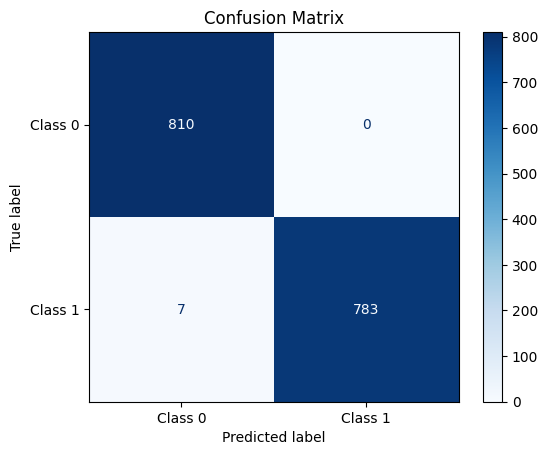

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.99      1.00      1.00       810
     Class 1       1.00      0.99      1.00       790

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Assuming you have already defined your test_ds and googlenet_model

all_true_labels = []
all_predicted_labels = []

for images_batch, labels_batch in test_ds:
    # Get true labels
    true_labels = labels_batch.numpy()
    all_true_labels.extend(true_labels)

    # Get predicted labels (binary classification expects a single output per sample)
    batch_predictions = model.predict(images_batch)
    batch_predictions = (batch_predictions >= 0.5).astype(int)
    print(batch_predictions)
    predicted_labels = (batch_predictions > 0.5).astype(int)  # Threshold at 0.5
    all_predicted_labels.extend(predicted_labels.flatten())

# Compute confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=["Class 0", "Class 1"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
report = classification_report(all_true_labels, all_predicted_labels, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)


In [ ]:
model.save('/content/drive/My Drive/VD5.h5')